In [6]:
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'} value to print more messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, DepthwiseConv2D, Dropout, Add, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, Model  
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(tf.test.gpu_device_name())


2.11.0
/device:GPU:0


Training Images range from 0.00000 to 1.00000
Test     Images range from 0.00000 to 1.00000
(32, 32, 3)


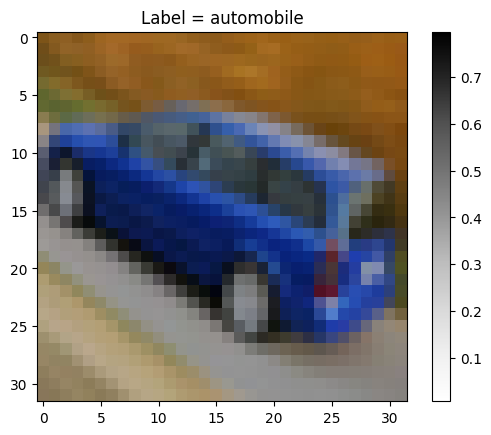

In [7]:
########################################
## Add code here to Load the CIFAR10 data set
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Now separate out a validation set.
val_frac = 0.1
num_val_samples = int(len(train_images)*val_frac)
# choose num_val_samples indices up to the size of train_images, !replace => no repeats
val_idxs = np.random.choice(np.arange(len(train_images)), size=num_val_samples, replace=False)
trn_idxs = np.setdiff1d(np.arange(len(train_images)), val_idxs)
val_images = train_images[val_idxs, :,:,:]
train_images = train_images[trn_idxs, :,:,:]

val_labels = train_labels[val_idxs]
train_labels = train_labels[trn_idxs]

train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()
val_labels = val_labels.squeeze()

input_shape  = train_images.shape[1:]
train_images = train_images / 255.0
test_images  = test_images  / 255.0
val_images   = val_images   / 255.0
print("Training Images range from {:2.5f} to {:2.5f}".format(np.min(train_images), np.max(train_images)))
print("Test     Images range from {:2.5f} to {:2.5f}".format(np.min(test_images), np.max(test_images)))

idx = 2401
plt.figure()
plt.imshow(val_images[idx], cmap='Greys')
plt.colorbar()
plt.grid(False)
plt.title("Label = {:}".format(class_names[val_labels[idx]]))
print(input_shape)

In [8]:
def build_model1():
    input_shape = (32, 32, 3)

    model = tf.keras.Sequential([
        Input(shape=input_shape, name='input'),
        Conv2D(32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='conv1'),
        BatchNormalization(name='batch1'),
        
        Conv2D(64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='conv2'),
        BatchNormalization(name='batch2'),
        
        Conv2D(128, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='conv3'),
        BatchNormalization(name='batch3'),
        
        Conv2D(128, kernel_size=(3,3), activation="relu", padding='same', name='conv5'),
        BatchNormalization(name='batch4'),

        Conv2D(128, kernel_size=(3,3), activation="relu", padding='same', name='conv6'),
        BatchNormalization(name='batch5'),

        Conv2D(128, kernel_size=(3,3), activation="relu", padding='same', name='conv7'),
        BatchNormalization(name='batch6'),

        Conv2D(128, kernel_size=(3,3), activation="relu", padding='same', name='conv8'),
        BatchNormalization(name='batch7'),

        #finishing layers
        MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool'),
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='dense1'),
        Dense(10, name='dense2')
    ], name='model_1')
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model


In [13]:
model = build_model1()

# print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 16, 16, 32)        896       
                                                                 
 batch1 (BatchNormalization)  (None, 16, 16, 32)       128       
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 64)          18496     
                                                                 
 batch2 (BatchNormalization)  (None, 8, 8, 64)         256       
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 128)         73856     
                                                                 
 batch3 (BatchNormalization)  (None, 4, 4, 128)        512       
                                                                 
 conv5 (Conv2D)              (None, 4, 4, 128)         1475

In [10]:
train_hist = model.fit(train_images, train_labels, 
                  validation_data=(val_images, val_labels), # or use `validation_split=0.1`
                  epochs=50)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(train_hist.history['accuracy'])
plt.plot(train_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Print a validation image and its corresponding label
val_image_idx = 2401  # change this to print a different validation image
plt.imshow(val_images[val_image_idx])
plt.title(f"Label: {val_labels[val_image_idx]}")
plt.show()

In [ ]:
model1=build_model1()

def count_layers(model, layer_type):
  lyr_count = 0
  for l in model.layers: 
    if l.__class__.__name__ == layer_type:
      lyr_count +=1 
  return lyr_count

def test_model1_params():
  assert model1.count_params() in [704842, 704330]

def test_model1_convs():
  n_convs = count_layers(model1, "Conv2D")
  assert n_convs == 7

def test_model1_batchnorm():
  n_bn = count_layers(model1, "BatchNormalization")
  assert n_bn in [7,8]


def test_model1_dense():
  n_dense = count_layers(model1, "Dense")
  assert n_dense == 2

In [ ]:
test_model1_batchnorm()
test_model1_params()
test_model1_convs()
test_model1_dense()